# Procesamiento de Imágenes - Trabajo Práctico N°4
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

# Ejercicio 8

## HDR

HDR o  High Dynamic Range es una técnica de posprocesamiento que utiliza varias imágenes de la misma escena tomadas a diferentes velocidades de obturación para combinarlas todas en una sola fotografía. Esta técnica busca resolver el problema relacionado con que el rango dinámico del ojo humano es mucho mayor que el de las cámaras digitales, en las cuales el rango de valores es generalmente guardado en 8 bits. El resultado de aplicar la técnica de HDR es una imagen con mayor cantidad de detalles tanto en las zonas de sombra como en las de luz, cercana a lo que apreciaría el ojo humano.

Como fue mencionado, el HDR utiliza imágenes de la misma escena tomadas a diferentes velocidad de obturación, lo cual está relacionado con la cantidad de luz que capturan. Es recomendable para aplicar HDR utilizar tanto imágenes subexpuestas, que capturan los detalles más claros; correctamente expuestas; y sobreexpuestas, que capturan los detalles más oscuros.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
# Add the folder path to the sys.path list
sys.path.append('../../src/helpers/')
from compare_images import compare_images

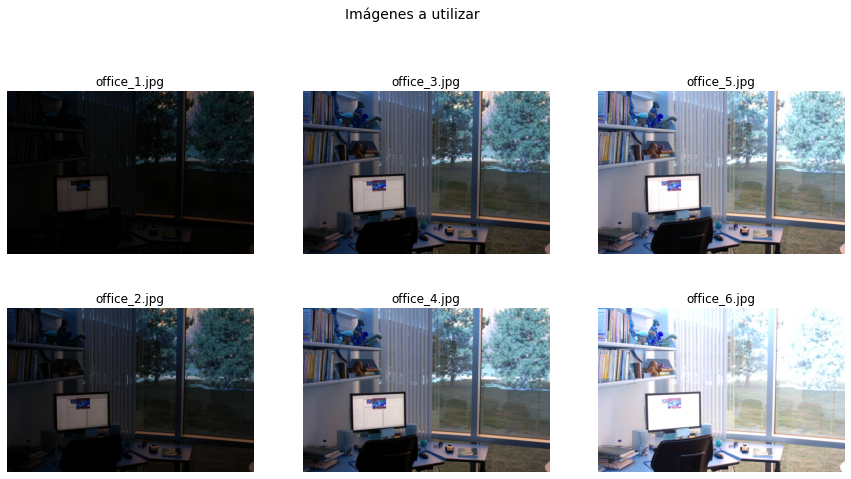

In [2]:
times = np.array([0.0333, 0.1000, 0.3333, 0.6250, 1.3000, 4.0000], dtype=np.float32)
filenames = ["office_" + str(i) + ".jpg" for i in range(1,7)]
dir_path = '../../assets/ej8/'
images = []
fig, axs = plt.subplots(2, 3, figsize=(15,8))
i = 0
j = 0
for filename in filenames:
    im = cv2.imread(dir_path + filename)
    images.append(im)
    axs[i,j].imshow(im)
    axs[i,j].axis('off')
    axs[i,j].set_title(filename)
    i+=1
    if (i == 2):
        i = 0
        j+=1
fig.suptitle("Imágenes a utilizar", fontsize=14)
plt.subplots_adjust( hspace=0)

## Aplicación de HDR

### Camera Response Function (CRF)

En primer lugar, es necesario estudiar como afecta la función de respuesta de la cámara (CRF) a las imágenes. La función de respuesta de la cámara relaciona la irradiación de la escena con las intensidades de la imagen.  Una CRF implica que los valores que toman los píxeles son directamente proporcionales al tiempo de exposición (excepto para valores extremos). Sin embargo, la respuesta de una cámara típica no es lineal a la luminosidad de la escena. Por esta razón, para aplicar HDR es necesario corregir esta alinealidad. Una vez realizado esto, es posible obtener la intensidad de cada píxel de la imagen final promediando las intensidades de las imágenes utilizadas (obtenidas dividiendo el valor del píxel por el tiempo de exposición).

![](../../assets/ej8/crf.png)

A fin corregir la alinealidad presente en la CRF es necesario, en primer lugar, estimar a esta función dado que es desconocida. La estimación de la CRF es un paso fundamental y necesario en muchas aplicaciones de procesamiento de imágenes, como la generación de imágenes con HDR, la estimación de la función de distribución de reflectancia bidireccional (BRDF), y otras. Esta estimación puede ser realizada si se conocen los tiempos de exposición. Para ello, se puede utilizar la función CalibrateDebevec de la librería OpenCV.



True

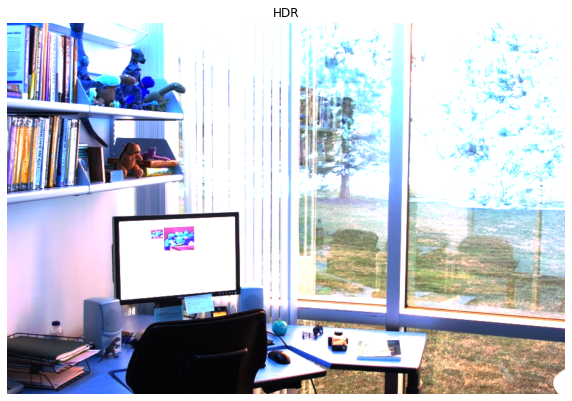

In [3]:
# Estimación de CRF
calibrateDebevec = cv2.createCalibrateDebevec()
responseDebevec = calibrateDebevec.process(images, times)

# Obtención de imagen HDR combinando las demás.
mergeDebevec = cv2.createMergeDebevec()
hdrDebevec = mergeDebevec.process(images, times, responseDebevec)

# Conversión a 8 bits
hdrDebevec_8bit = np.clip(hdrDebevec*255, 0, 255).astype('uint8')

# Plot
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(hdrDebevec_8bit)
plt.axis('off')
plt.title('HDR')

# Guardo imagen resultante
cv2.imwrite("output/hdrDebevec.hdr", hdrDebevec_8bit)

### Tone Mapping

La imagen obtenida anteriormente es el resultado de la combinación de las imágenes utilizadas. Sin embargo, para poder visualizar dicha imagen fue necesario recortar los valores al rango [0-255]. Este recorte genera que parte de la información sea perdida y que todos los valores por encima del 255 sean interpretados como blanco. Este comportamiento es notorio en la imagen mostrada, donde gran parte los píxeles visualizados son blancos.

A continuación se grafican los histogramas de la imagen obtenida sin recortar y de la imagen recortada.

#### Histograma sin recortar

Text(0.5, 1.0, 'Sin recorte')

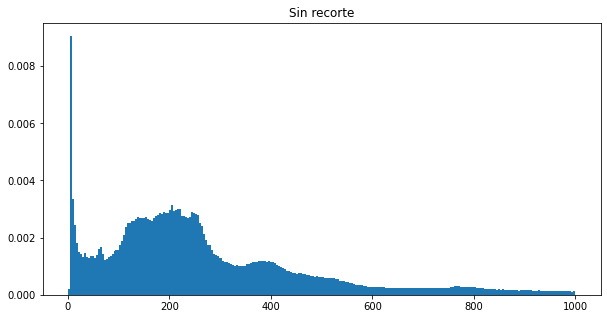

In [4]:
fig, ax = plt.subplots(figsize=(10,5))
hdr = hdrDebevec*255
N1, bins1, _= ax.hist(hdr.ravel(),256,[0,1000], density=True)
ax.set_title('Sin recorte')

En el histograma de la imagen sin recortar se aprecia que existen valores por encima de 255.

#### Histograma con recorte

Text(0.5, 1.0, 'Con recorte')

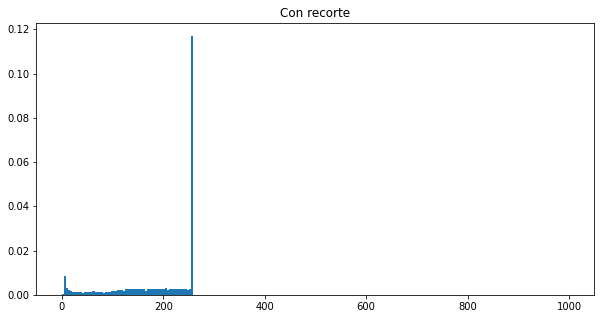

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
N1, bins1, _= ax.hist(hdrDebevec_8bit.ravel(),256,[0,1000], density=True)
ax.set_title('Con recorte')

Al recortar los valores por encima de 255 se pierde parte del histograma y dichos valores son considerados blancos.

#### Aplicación de Tone Mapping

Tone Mapping es el proceso de convertir una imagen de alto rango dinámico (HDR) en una imagen de 8 bits por canal conservando el máximo detalle posible. Por ello, este proceso es una mejor opción que el recorte aplicado anteriormente.

Así como para la estimación de la CRF, el Tone Mapping puede ser aplicado utilizando la librería OpenCV. En específico, la función a ejecutar es createTonemap, la cual recibe un parámetro con el cual realiza corrección gamma.

True

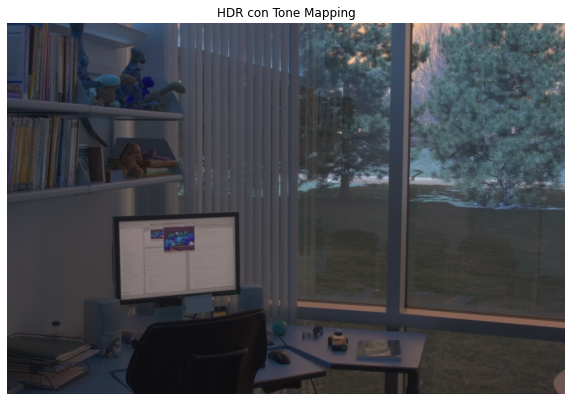

In [6]:
# Creación de ToneMap
tonemap1 = cv2.createTonemap(gamma=2.7)

# Aplicación de Tone Mapping
res_debevec = tonemap1.process(hdrDebevec.copy())

# Desnormalización
res_debevec_8bit = np.clip(res_debevec*255, 0, 255).astype('uint8')

# Plot
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(res_debevec_8bit,cmap='gray')
plt.axis('off')
plt.title('HDR con Tone Mapping')

# Guardo imagen resultante
cv2.imwrite("output/res_debevec.hdr", res_debevec_8bit)

Text(0.5, 1.0, 'Con Tone Mapping')

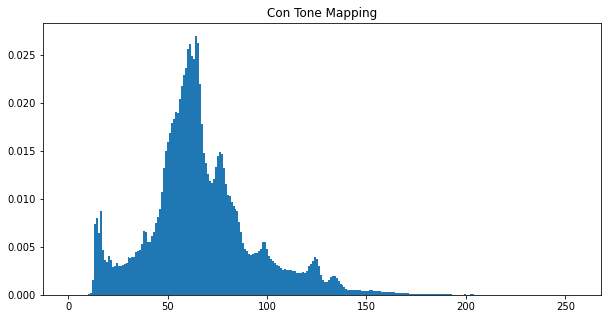

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
N1, bins1, _= ax.hist(res_debevec_8bit.ravel(),256,[0,255], density=True,)
ax.set_title('Con Tone Mapping')

Al aplicar Tone Mapping, los colores de la imagen resultante son interpretados correctamente. En este caso, a diferencia de la no aplicación de Tone Mapping, no se advierte la presencia de píxeles blancos donde no deberían encontrarse. Esto, como fue mencionado, se debe a que el histograma no es recortado al rango de 8 bits sino que es mapeado junto con la utilización de una corrección gamma.

## Conclusión
A modo de conclusión, en el presente ejercicio se utilizaron 6 imágenes con distintos tiempos de exposición a fin de aplicar la técnica de HDR. Para aplicarla, fue necesario realizar una estimación de la CRF y reconvertirla en una función lineal. Una vez realizado este paso, las imágenes fueron combinadas promediando los valores de intensidad. Además, se incorporó el concepto de Tone Mapping y se compararon los resultados con el uso de este proceso y sin él. La imagen obtenida luego de realizar completamente el proceso resulta muy similar a lo visualizado por el ojo humano sin utilizar una cámara digital, a diferencia de lo que sucede en las 6 imágenes utilizadas.